## Confirming Interrupt Frequency Across 1 Millisecond Measurements

#### For every log file, isolating CPU-level metrics from NIC-level metrics results in a sparse matrix of zero-filled log entries amongst non-zero filled log entries that are about 1 millisecond apart.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import eigen_analysis

In [68]:
cd 400k_qps/

[Errno 2] No such file or directory: '400k_qps/'
/home/tanneen/energy_project/full_logs/400k_qps


### Testing for 1 Log File 

In [90]:
fname = 'linux_mcd_dmesg_0_0x1100_135_400k/linux.mcd.dmesg.0_13_30_0x1100_135_400000'
rdtsc_fname = 'linux_mcd_rdtsc_0_0x1100_135_400k/linux.mcd.rdtsc.0_30_0x1100_135_400000'
qps = '400k'
dvfs = '0x1100'
itr = '30'
cols = eigen_analysis.LINUX_COLS
start, end = eigen_analysis.get_rdtsc(rdtsc_fname)

In [91]:
df = pd.read_csv(fname, sep= ' ', names = cols, index_col='i')
df = df[['instructions', 'cycles', 'ref_cycles', 'llc_miss', 'joules', 'timestamp']]

#### Translating timestamp measurements to time units (seconds)

In [92]:
df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
df['timestamp'] = df['timestamp'] - df['timestamp'].min()
df['timestamp'] = df['timestamp'] * eigen_analysis.TIME_CONVERSION_khz
df

,instructions,cycles,ref_cycles,llc_miss,joules,timestamp
i,,,,,,
144,5178098632121,8873643203555,11436383168004,15772326323,3268899285,0.000000
145,0,0,0,0,0,0.000071
146,0,0,0,0,0,0.000100
147,0,0,0,0,0,0.000136
148,0,0,0,0,0,0.000166
...,...,...,...,...,...,...
578138,0,0,0,0,0,20.004311
578139,0,0,0,0,0,20.004342
578140,0,0,0,0,0,20.004373


#### Checking number of log entries (i.e. interrupts) within 1 millisecond intervals

In [93]:
# translating timestamps to timestamp diffs
df['timestamp'] = df['timestamp'].diff()

In [94]:
df

,instructions,cycles,ref_cycles,llc_miss,joules,timestamp
i,,,,,,
144,5178098632121,8873643203555,11436383168004,15772326323,3268899285,NaN
145,0,0,0,0,0,0.000071
146,0,0,0,0,0,0.000028
147,0,0,0,0,0,0.000036
148,0,0,0,0,0,0.000030
...,...,...,...,...,...,...
578138,0,0,0,0,0,0.000030
578139,0,0,0,0,0,0.000031
578140,0,0,0,0,0,0.000031


In [95]:
# looping over all rows and adding timestamp diffs to count number of interrupts between 1 ms boundaries
time_diff = 0
n_itrs = []
k = 0
for i,j in df.iterrows():
    if j['timestamp'] >= 0:
        time_diff += j['timestamp']
    k += 1
    if time_diff >= 0.001:
        n_itrs.append(k)
        time_diff = 0
        k = 0

In [96]:
# calculating expected number of interrupts per ms
expected_n_itr = 1000 / int(itr)
expected_n_itr

33.333333333333336

n_per_bin:  [7.000e+00 2.000e+01 6.000e+01 1.140e+02 1.640e+02 5.380e+02 1.070e+03
 3.174e+03 6.652e+03 7.818e+03]


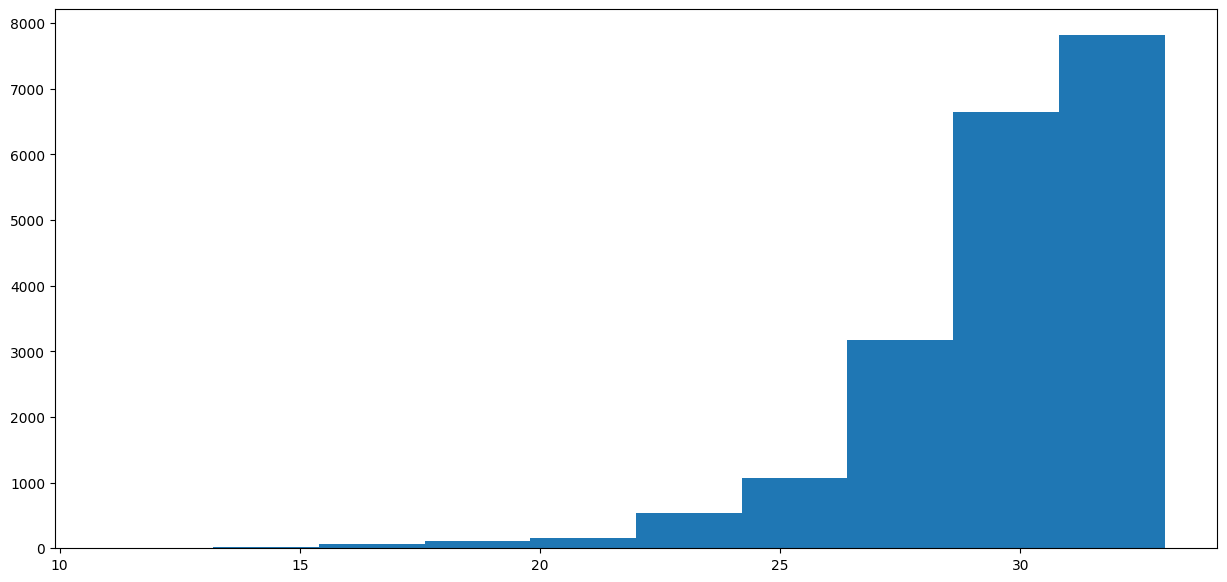

In [97]:
# showing frequency of number of interrupts per ms
fig, ax = plt.subplots(figsize =(15, 7))
n_per_bin, bins, _ = ax.hist(n_itrs)
print('n_per_bin: ', n_per_bin)
plt.show()

### Testing for 16 Log Files (1 file per core) 

In [69]:
#dirname = 'linux_mcd_dmesg_0_0x1100_135_400k/'
#rdtsc_dir = 'linux_mcd_rdtsc_0_0x1100_135_400k/'
#qps = '400000'
#dvfs = '0x1100'
#rapl = '135'
#run = '0'
cols = eigen_analysis.LINUX_COLS
itrs = []

In [55]:
# get all itrs explored within a directory
for file in os.listdir(dirname):
    tags = file.split('_')
    itr = tags[2]
    itrs.append(int(itr))
itrs = set(itrs)
itrs

{2, 10, 20, 30, 40, 50, 100, 200, 250, 300, 350, 400}

In [73]:
def plot_itrs_per_ms(itr, dvfs, qps, run, rapl):
    dirname = 'linux_mcd_dmesg_'+ run + '_' + dvfs + '_' + rapl + '_' + str(int(int(qps)/1000)) + 'k/'
    rdtsc_dir = 'linux_mcd_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + str(int(int(qps)/1000)) + 'k/'

    rdtsc_file = 'linux.mcd.rdtsc.' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps
    rdtsc_fname = rdtsc_dir + rdtsc_file
    start, end = eigen_analysis.get_rdtsc(rdtsc_fname)
    for core in range(0,16):
        fname = dirname + 'linux.mcd.dmesg.' + run + '_' + str(core) + '_' + str(itr) + '_' + dvfs + '_' + rapl + '_' + qps

        df = pd.read_csv(fname, sep= ' ', names = cols, index_col='i')
        df = df[['instructions', 'cycles', 'ref_cycles', 'llc_miss', 'joules', 'timestamp']]
        df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
        df['timestamp'] = df['timestamp'] - df['timestamp'].min()
        df['timestamp'] = df['timestamp'] * eigen_analysis.TIME_CONVERSION_khz
        df['timestamp'] = df['timestamp'].diff()

        print(fname)

        time_diff = 0
        n_itrs = []
        k = 0
        for i,j in df.iterrows():
            if j['timestamp'] >= 0:
                time_diff += j['timestamp']
            k += 1
            if time_diff >= 0.001:
                n_itrs.append(k)
                time_diff = 0
                k = 0

        expected_n_itr = 1000 / int(itr)
        print('expected # interrupts =  ', str(1000) + '/' + itr + ' = ', expected_n_itr)

        fig, ax = plt.subplots(figsize =(15, 7))
        n_per_bin, bins, _ = ax.hist(n_itrs)
        print('bins: ' , bins, ' , n_per_bin: ', n_per_bin)
        plt.show()

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_0_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 7.   8.4  9.8 11.2 12.6 14.  15.4 16.8 18.2 19.6 21. ]  , n_per_bin:  [3.0000e+00 2.0000e+00 2.0000e+01 2.5000e+01 4.5000e+01 2.3700e+02
 2.2200e+02 1.5480e+03 4.3410e+03 1.3004e+04]


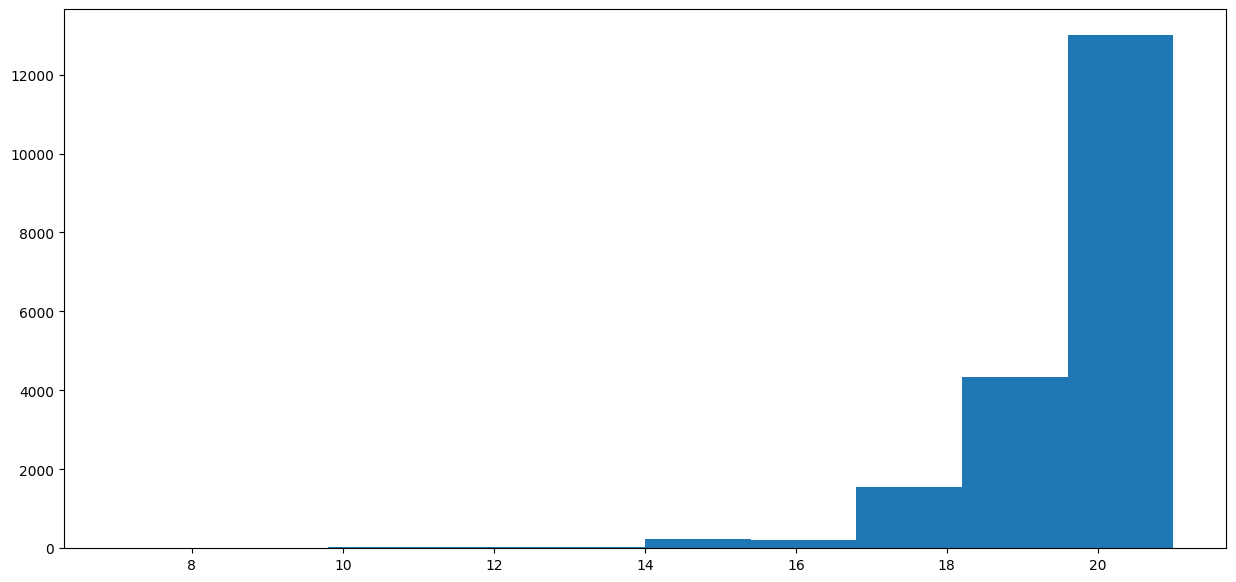

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_1_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 4.   5.6  7.2  8.8 10.4 12.  13.6 15.2 16.8 18.4 20. ]  , n_per_bin:  [1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+01 2.3000e+01 1.1900e+02
 3.0200e+02 2.9300e+02 1.7220e+03 1.6975e+04]


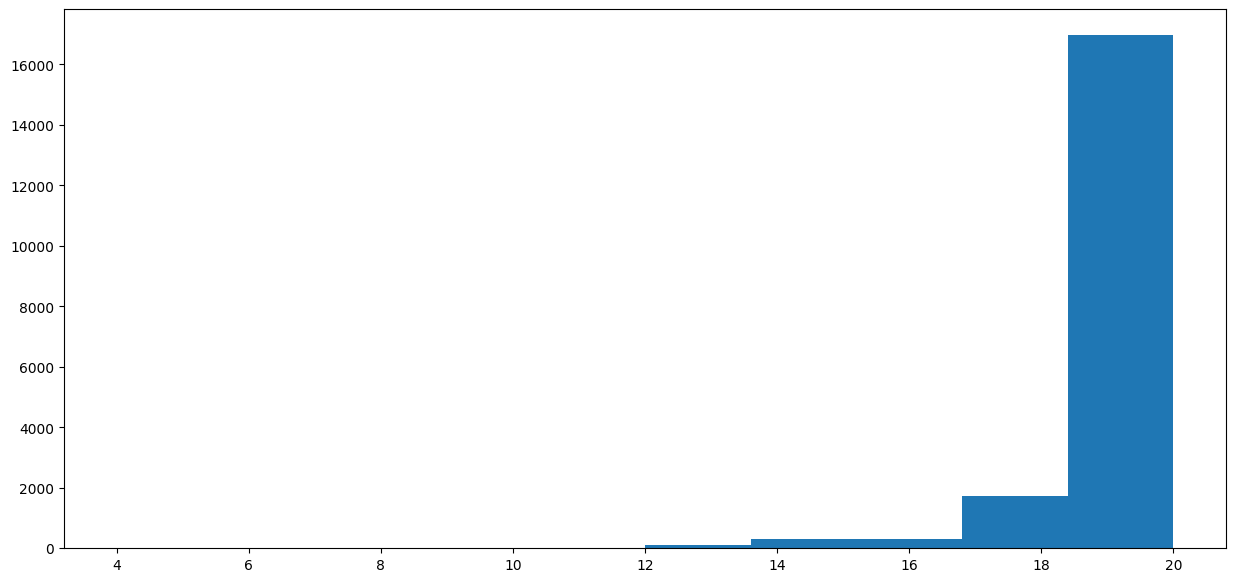

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_2_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 8.   9.3 10.6 11.9 13.2 14.5 15.8 17.1 18.4 19.7 21. ]  , n_per_bin:  [2.0000e+00 1.0000e+00 1.0000e+01 4.9000e+01 7.3000e+01 1.2900e+02
 4.8200e+02 9.8700e+02 4.3220e+03 1.3397e+04]


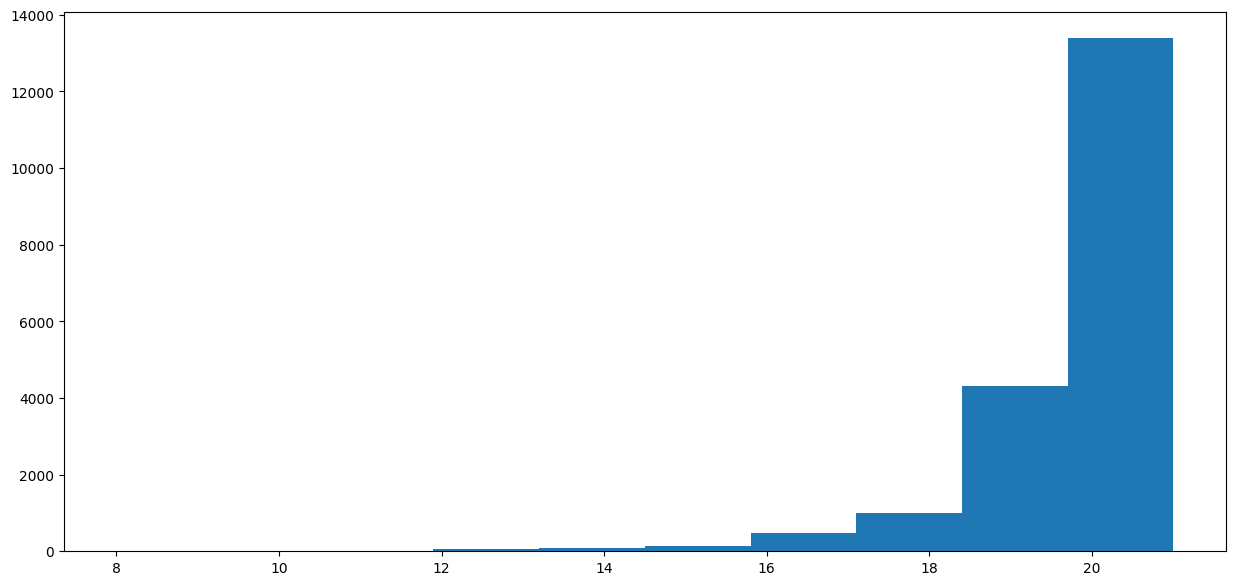

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_3_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 5.   6.5  8.   9.5 11.  12.5 14.  15.5 17.  18.5 20. ]  , n_per_bin:  [2.0000e+00 1.0000e+00 6.0000e+00 8.0000e+00 5.2000e+01 6.0000e+01
 2.7700e+02 2.5500e+02 1.5630e+03 1.7221e+04]


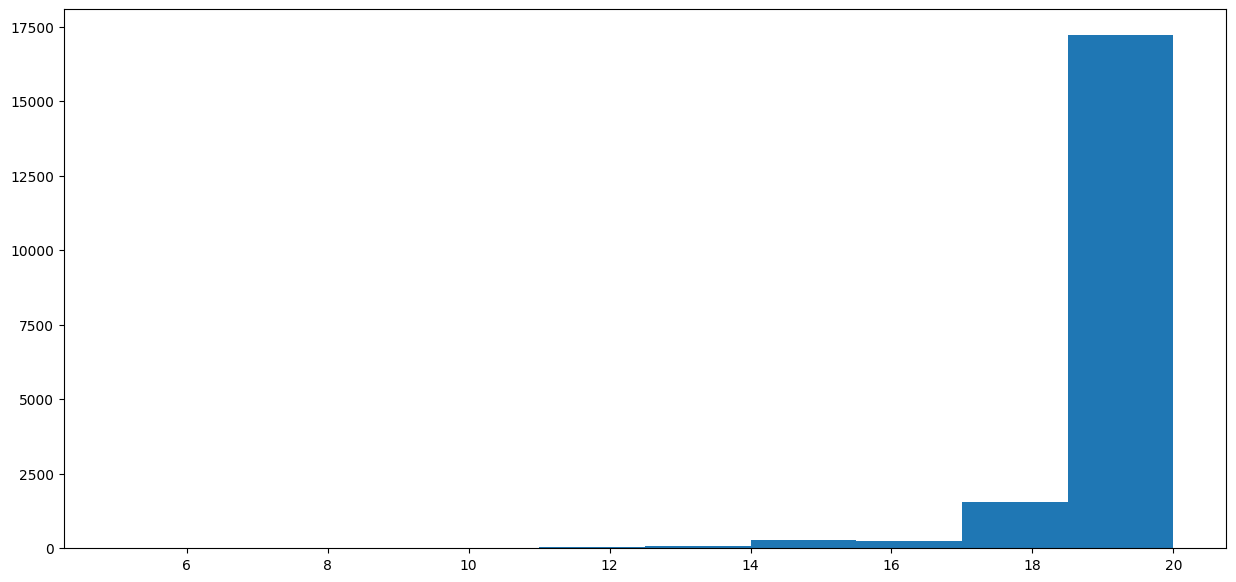

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_4_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 8.   9.3 10.6 11.9 13.2 14.5 15.8 17.1 18.4 19.7 21. ]  , n_per_bin:  [7.0000e+00 1.2000e+01 1.5000e+01 8.0000e+01 8.1000e+01 1.6600e+02
 6.2900e+02 1.1510e+03 4.3350e+03 1.2972e+04]


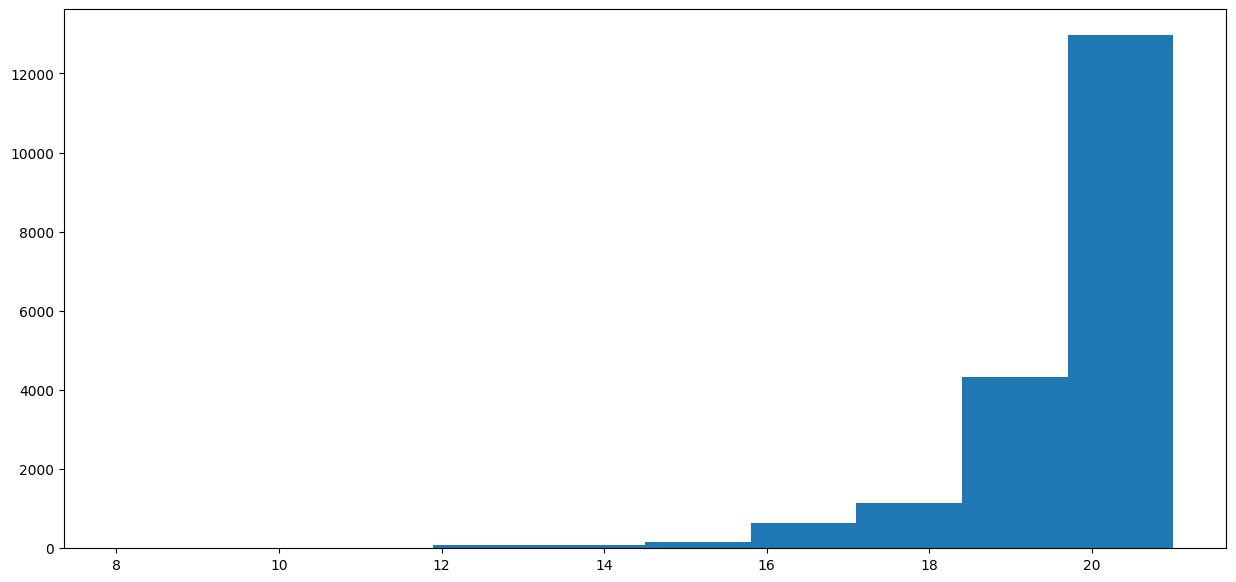

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_5_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 9.  10.1 11.2 12.3 13.4 14.5 15.6 16.7 17.8 18.9 20. ]  , n_per_bin:  [1.100e+01 1.200e+01 3.100e+01 5.500e+01 1.030e+02 1.500e+02 2.510e+02
 4.810e+02 1.190e+03 1.716e+04]


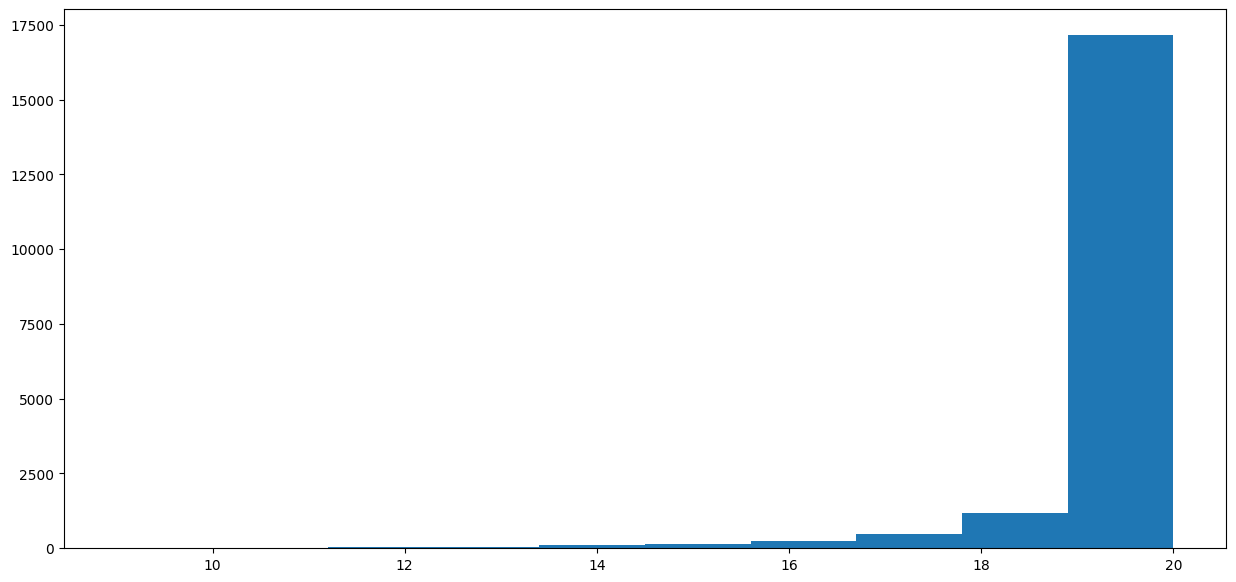

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_6_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 8.   9.3 10.6 11.9 13.2 14.5 15.8 17.1 18.4 19.7 21. ]  , n_per_bin:  [6.0000e+00 2.0000e+00 1.0000e+01 6.7000e+01 6.4000e+01 1.1100e+02
 5.8900e+02 1.0320e+03 4.4280e+03 1.3141e+04]


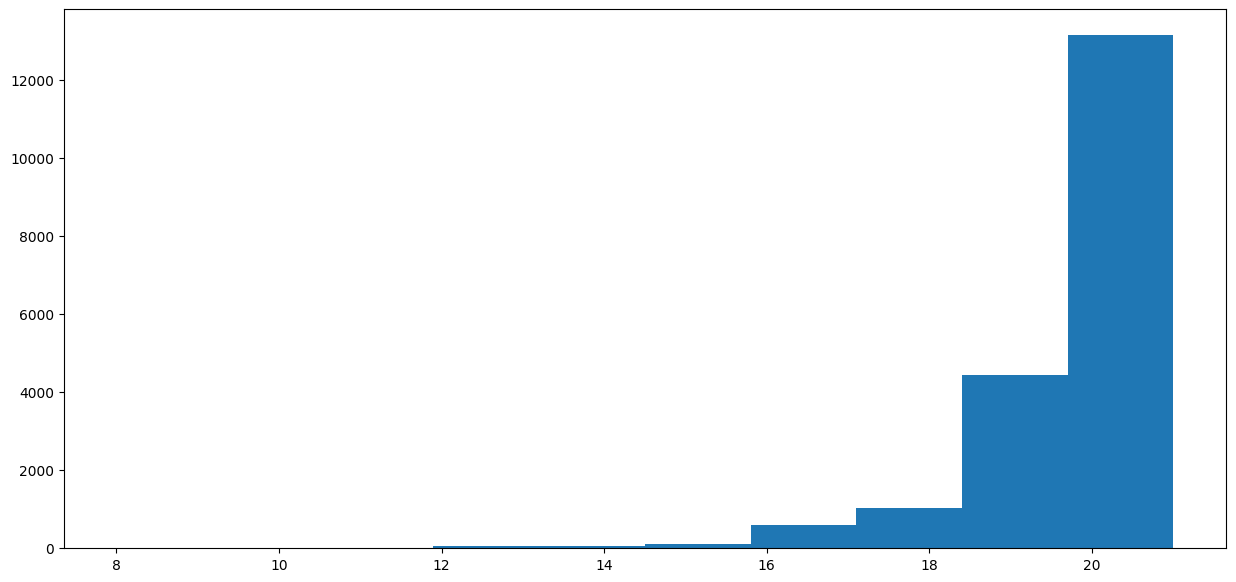

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_7_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 7.   8.3  9.6 10.9 12.2 13.5 14.8 16.1 17.4 18.7 20. ]  , n_per_bin:  [5.0000e+00 2.0000e+00 6.0000e+00 3.4000e+01 5.3000e+01 9.5000e+01
 4.0200e+02 4.1700e+02 1.1020e+03 1.7327e+04]


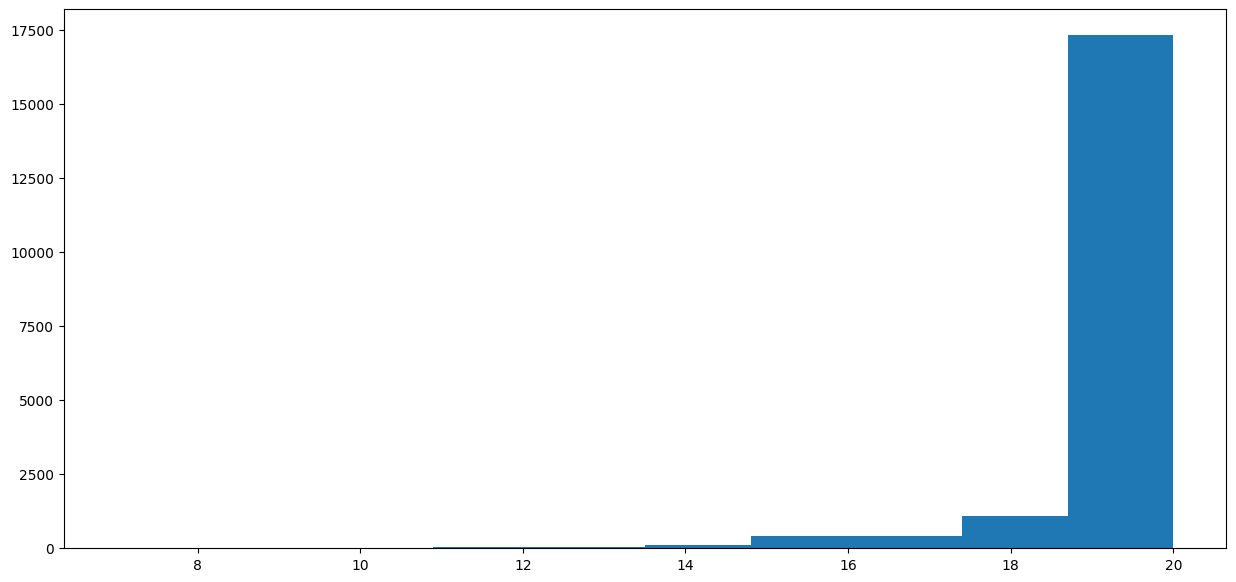

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_8_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 8.   9.2 10.4 11.6 12.8 14.  15.2 16.4 17.6 18.8 20. ]  , n_per_bin:  [8.0000e+00 1.1000e+01 2.1000e+01 3.6000e+01 5.1000e+01 2.5400e+02
 2.4100e+02 3.9800e+02 1.1290e+03 1.7298e+04]


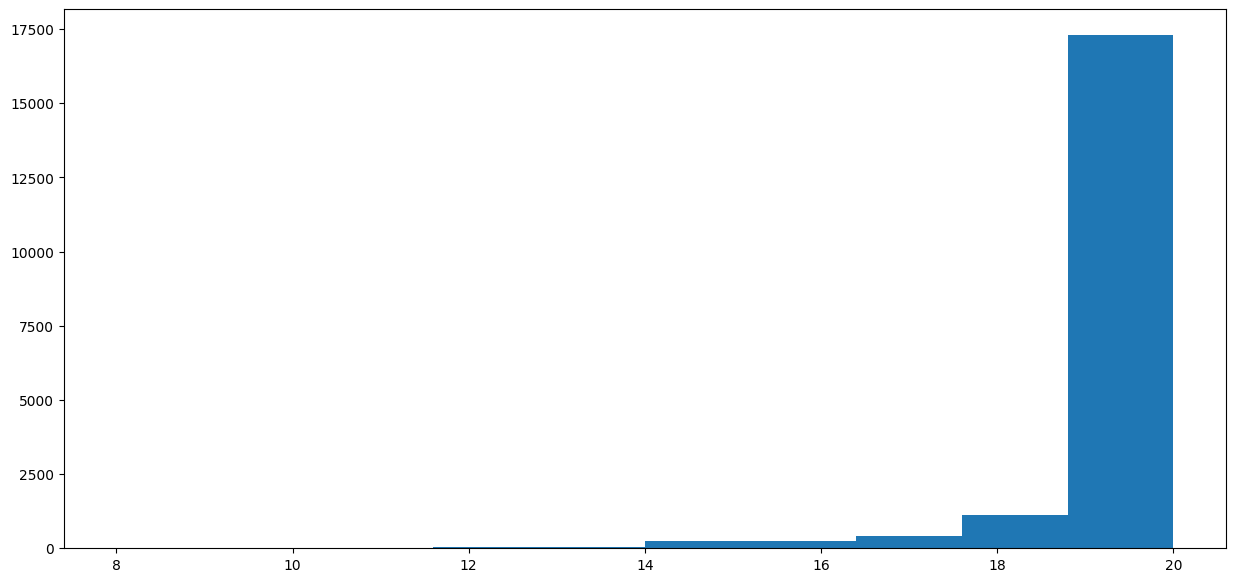

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_9_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 6.   7.4  8.8 10.2 11.6 13.  14.4 15.8 17.2 18.6 20. ]  , n_per_bin:  [1.0000e+00 1.0000e+00 5.0000e+00 6.0000e+00 2.6000e+01 1.3500e+02
 1.3400e+02 6.6100e+02 1.1150e+03 1.7365e+04]


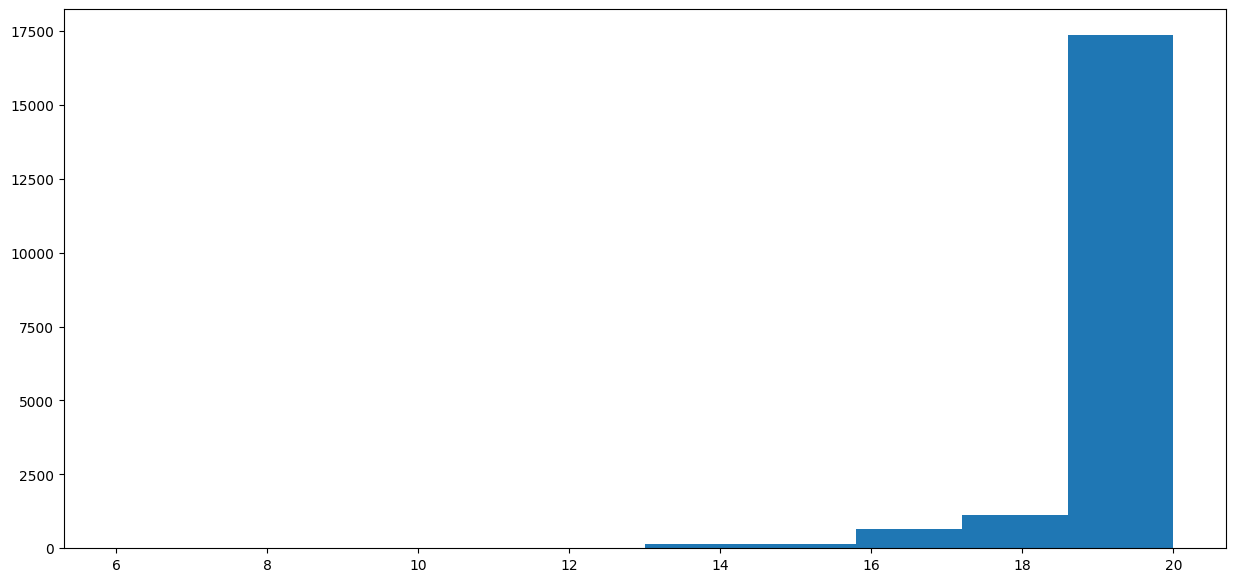

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_10_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 5.   6.5  8.   9.5 11.  12.5 14.  15.5 17.  18.5 20. ]  , n_per_bin:  [3.0000e+00 0.0000e+00 4.0000e+00 2.0000e+00 5.1000e+01 6.0000e+01
 2.3800e+02 2.3200e+02 1.5020e+03 1.7355e+04]


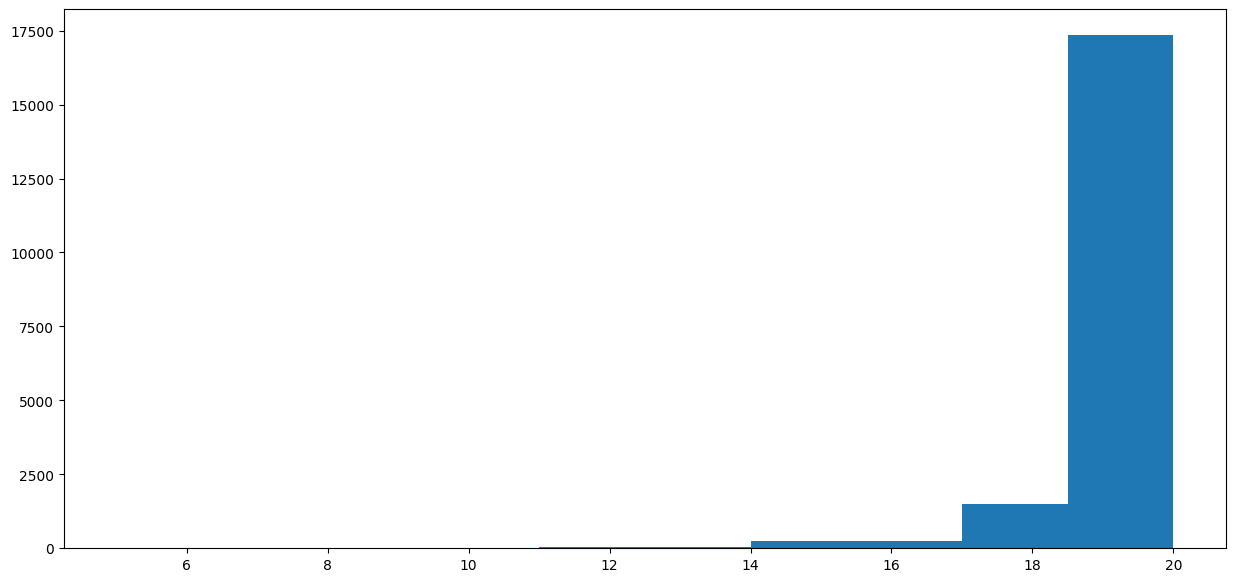

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_11_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 7.   8.3  9.6 10.9 12.2 13.5 14.8 16.1 17.4 18.7 20. ]  , n_per_bin:  [4.0000e+00 3.0000e+00 1.1000e+01 4.5000e+01 4.0000e+01 7.6000e+01
 4.0800e+02 4.6600e+02 1.1550e+03 1.7239e+04]


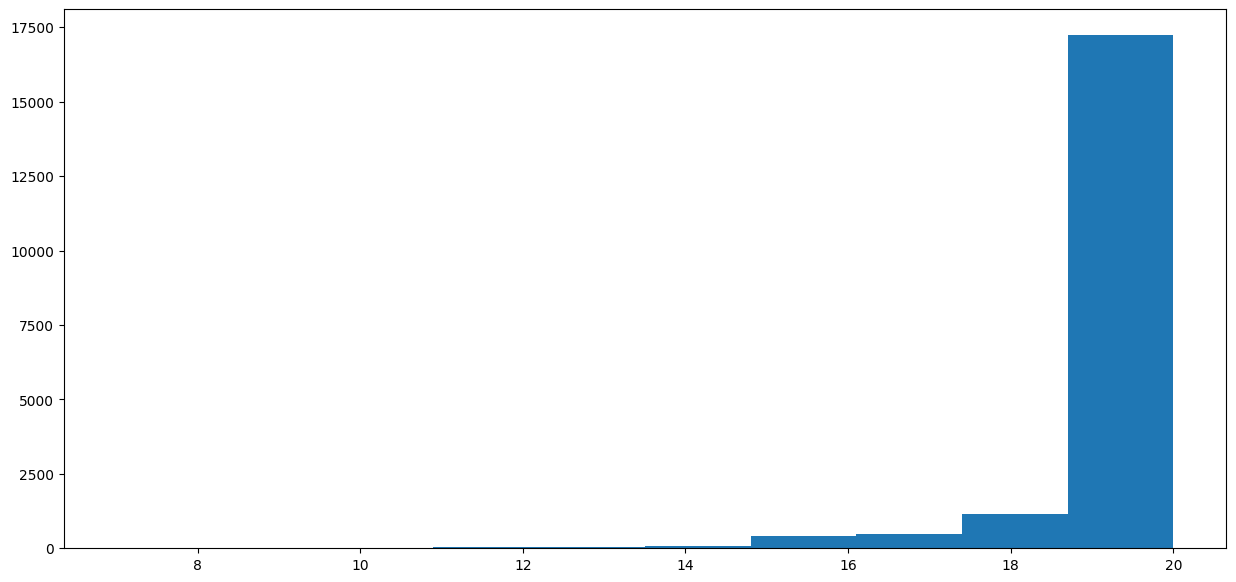

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_12_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 8.   9.3 10.6 11.9 13.2 14.5 15.8 17.1 18.4 19.7 21. ]  , n_per_bin:  [3.0000e+00 5.0000e+00 1.4000e+01 7.4000e+01 8.1000e+01 1.1700e+02
 6.7000e+02 1.1250e+03 4.4590e+03 1.2895e+04]


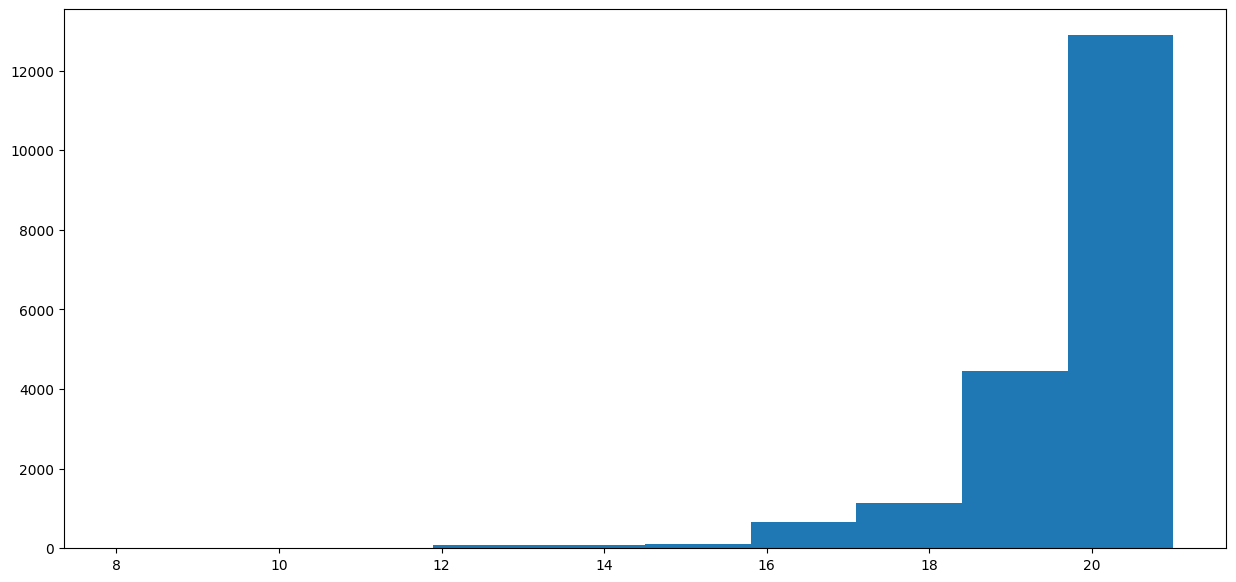

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_13_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [10.  11.1 12.2 13.3 14.4 15.5 16.6 17.7 18.8 19.9 21. ]  , n_per_bin:  [   13.    33.    69.   109.   160.   250.   440.  1245.  4527. 12599.]


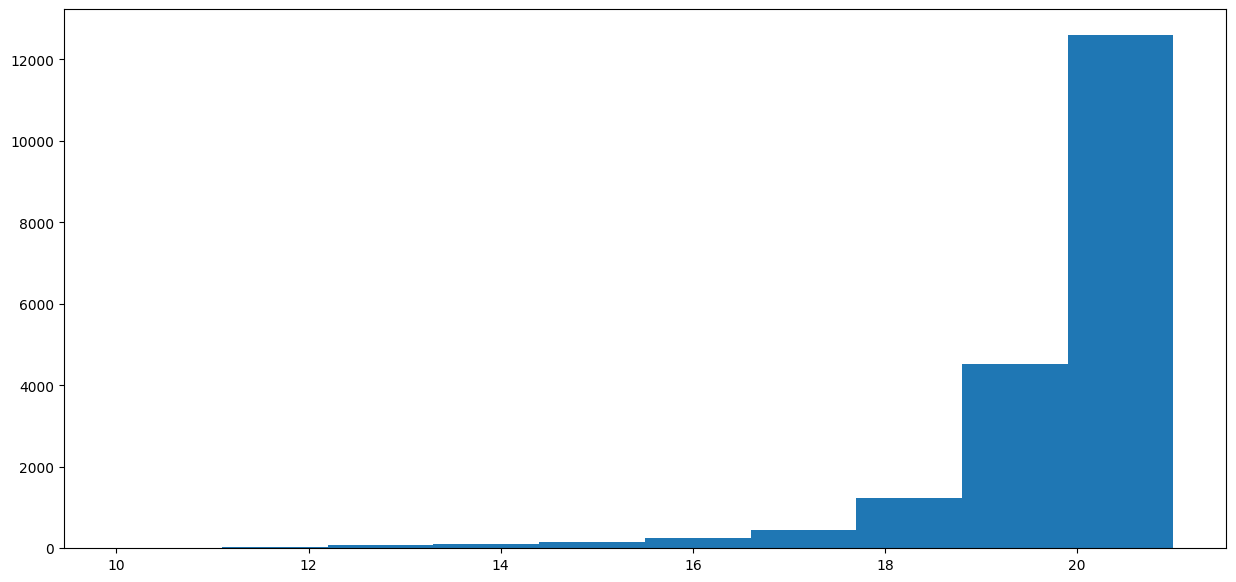

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_14_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [10.  11.1 12.2 13.3 14.4 15.5 16.6 17.7 18.8 19.9 21. ]  , n_per_bin:  [   14.    15.    39.    68.   115.   176.   392.  1097.  4353. 13180.]


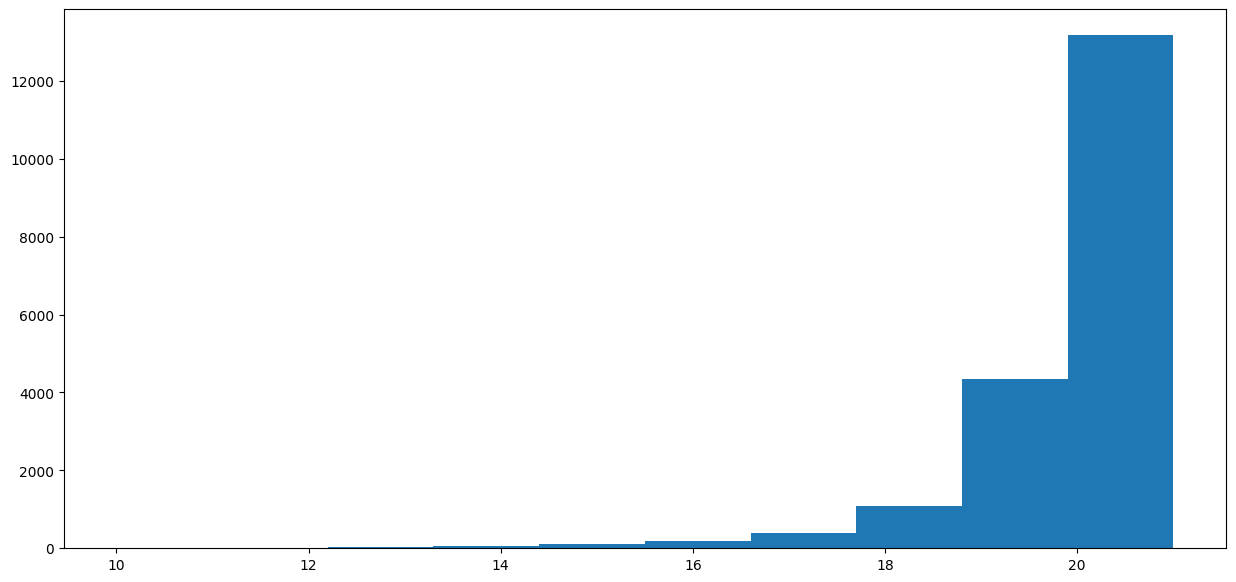

linux_mcd_dmesg_0_0xd00_135_400k/linux.mcd.dmesg.0_15_50_0xd00_135_400000
expected # interrupts =   1000/50 =  20.0
bins:  [ 9.  10.2 11.4 12.6 13.8 15.  16.2 17.4 18.6 19.8 21. ]  , n_per_bin:  [   16.    25.    34.    75.   139.   531.   505.  1272.  4483. 12360.]


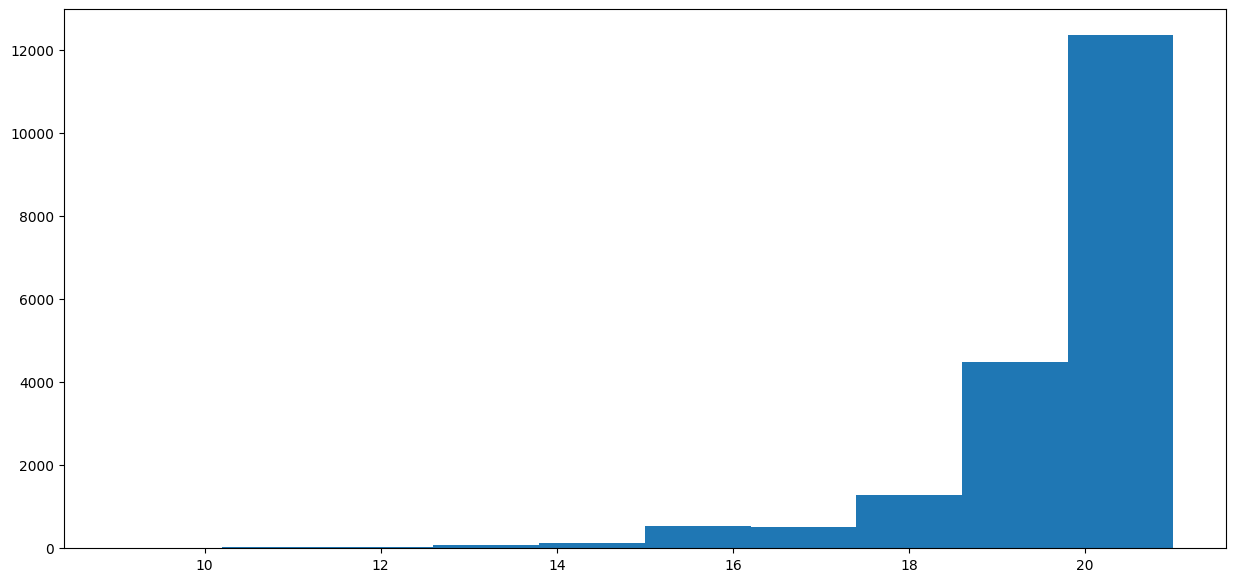

In [74]:
plot_itrs_per_ms('50', '0xd00', '400000', '0', '135')